# A TUTORIAL ON DETERMINISTIC ALGORITHMS FOR UNCONSTRAINED, CONTINUOUS-VALUED OPTIMIZATION

by Sebastian T. Glavind, February, 2021

In [1]:
import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt
%matplotlib inline

# import scipy.stats as ss
# import scipy.special as ssp
# import seaborn as sns
# import pandas as pd
# import pickle

# Introduction

In this tutorial, we will study a set of deterministic derivative-based and direct algorithms for unconstraint, continuous-valued optimization, namely first-order methods, like gradient decent (GD) and its variations (e.g., conjugate gradient decent and Adam); second-order methods, i.e., Newton's method and quasi-Newton methods (DFP and BFGS); and direct methods, i.e., coordinate decent and the Nelder-Mead simplex method. For a reference on the algorithms, see Kochenderfer&Wheeler(2019).

***
Kochenderfer, M. J., & Wheeler, T. A. (2019). Algorithms for optimization. Mit Press.
***

# Objective functions

We will start out by considering the following simple, convex objective function:

$$ f(\mathbf{x}) = f(x_1, ..., x_n) = \sum_{i=1}^n x_i^2,$$

and then continue to study the Ackley function:

$$ f(\textbf{x}) = - a \exp( -b \sqrt{ \frac{1}{n} \sum_{i=1}^{n} x_i^2} ) - \exp( \frac{1}{n} \sum_{i=1}^{n} \cos(c x_i)) + a + \exp(1), $$

where the values $a$, $b$ and $c$ are constants, which are usually chosen to be $a=20$, $b=0.2$ and $c=2\pi$. This function is a common benchmark problem in optimization, with global optima at $f(\mathbf{0})=0$.

In order to study the optimization graphically, we will consider both functions in two-dimensional space;

In [2]:
###########################################################################
# Objective functions and corresponding gradients
###########################################################################

# objective function A: Quadratic function
def objective_a(xx):
    x1, x2 = xx[0], xx[1]    
    # Output
    return( x1**2 + x2**2 )

def gradient_a(xx):
    x1, x2 = xx[0], xx[1]  
    # Output
    return( np.asarray([ 2*x1, 2*x2 ]) )

def hessian_a(xx): 
    # Note that no input is needed in this case as the hessian only includes constant terms
    # Output
    return( np.array([[2,0],[0,2]]) )


# # objective function B: Ackley function
# https://en.wikipedia.org/wiki/Ackley_function
# https://machinelearningmastery.com/how-to-use-nelder-mead-optimization-in-python/
def objective_b(xx):
    x1, x2 = xx[0], xx[1] 
    a = 20; b = 0.2; c = 2*np.pi;
    # Output
    return( -a * np.exp(-b * np.sqrt(0.5 * (x1**2 + x2**2))) - np.exp(0.5 * (np.cos(c * x1) + np.cos(c * x2))) + a + np.exp(1) )

def gradient_b(xx):
    x1, x2 = xx[0], xx[1] 
    a = 20; b = 0.2; c = 2*np.pi;	
    # Gradients
    g_x1 = (0.5 * a * b * x1 * np.exp( -b * np.sqrt( 0.5*x1**2 + 0.5*x2**2 ) ) )/np.sqrt( 0.5*x1**2 + 0.5*x2**2 ) + 0.5 * c * np.sin( c * x1) * np.exp( 0.5 * np.cos( c * x1) + 0.5 * np.cos( c * x2) )
    g_x2 = (0.5 * a * b * x2 * np.exp( -b * np.sqrt( 0.5*x1**2 + 0.5*x2**2 ) ) )/np.sqrt( 0.5*x1**2 + 0.5*x2**2 ) + 0.5 * c * np.sin( c * x2) * np.exp( 0.5 * np.cos( c * x1) + 0.5 * np.cos( c * x2) )
    # Output
    return( np.asarray([ g_x1, g_x2 ]) )


###########################################################################
# Plotting function for objective function 
###########################################################################

def objective_plot(xx_grid, obj_grid, plot_title):
    # create a surface plot with the jet color scheme
    fig = plt.figure(figsize=(16,6))
    fig.subplots_adjust(wspace=0.3)

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(xx_grid[0], xx_grid[1], obj_grid, cmap='jet')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$f$')

    ax = fig.add_subplot(1, 2, 2)
    con = ax.contourf(xx_grid[0], xx_grid[1], obj_grid, levels=50, cmap='jet')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_aspect('equal')

    # Add colorbar and title
    fig.subplots_adjust(right=0.8)
    cbar = fig.colorbar(con)
    cbar.ax.set_ylabel('$f$')
    fig.suptitle(plot_title, fontsize=13, y=0.95)

    # show the plot
    plt.show()

## Objective function A

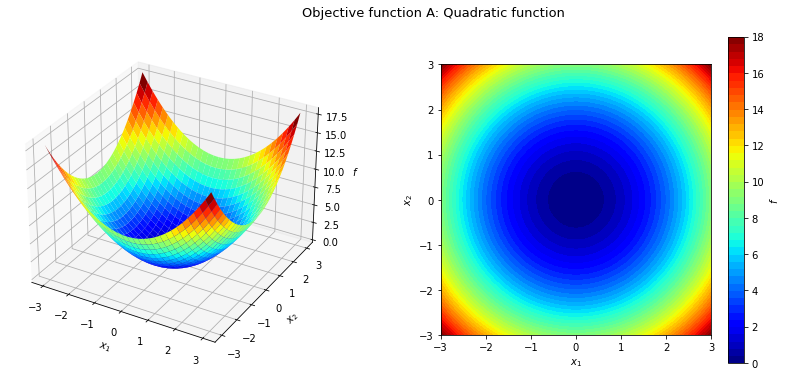

In [3]:
# define range for input
r_obj_a = np.array([-3.0, 3.0])
# sample input range uniformly at 0.1 increments
xstep_a = 0.1
xaxis_a = np.arange(r_obj_a[0], r_obj_a[1]+xstep_a, xstep_a)
# create a mesh from the axis
xx_a = np.meshgrid(xaxis_a, xaxis_a)
# compute targets
eval_obj_a = objective_a(xx_a)    
# Plot
objective_plot(xx_a, eval_obj_a, 'Objective function A: Quadratic function')

## Objective function B

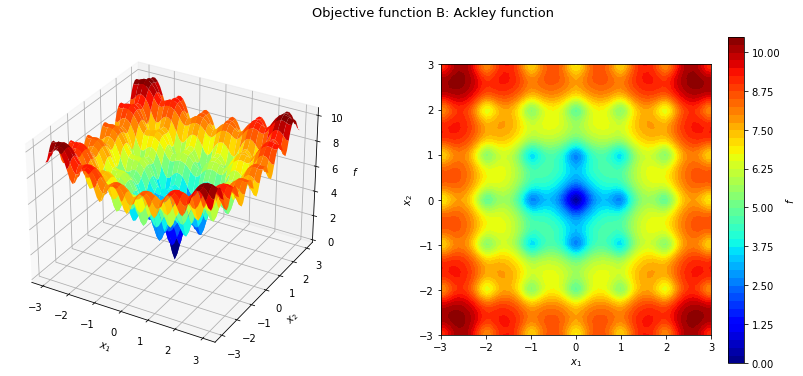

In [4]:
# create a mesh from the axis
xx_b = xx_a
# compute targets
eval_obj_b = objective_b(xx_b)    
# Plot
objective_plot(xx_b, eval_obj_b, 'Objective function B: Ackley function')

# First-order methods

In this section, we consider a set of local, first-order optimization algorithms, namely gradient decent and its variants, conjugate gradient decent, and Adam.

## Gradient decent

In the section, we consider three implementations of gradient decent (GD): (i) GD with decaying step factor, (ii) GD with backtracking (appriximate line search) step factor, and (iii) GD with line search for step factor. For each of the implementations, we conduct the optimization for both objective A and B.

In [5]:
###########################################################################
# Gradient decent with decaying step factor
###########################################################################

def GD_AjustDecay(f_obj, g_obj, xv0, alpha0, gamma0, kmax=100, precision=1e-8):
    xv = xv0
    obj = f_obj(xv)
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    for k in range(kmax):
        g_k = g_obj(xv) # gradient
        d_k = - g_k / np.sqrt(np.dot(g_k, g_k)) # search dir. - normalize gradient to length 1, see Kochenderfer & Wheelser (2019; Eq. 5.2)
        alpha_k = alpha0 * gamma0**(k) # decaying step factor, see Kochenderfer & Wheelser (2019; Eq. 4.3)
        xv +=  alpha_k * d_k
        obj = f_obj(xv)
#         print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        # book keeping
        xTrace.append(xv.copy())
        objTrace.append(obj.copy())
        # convergance (early stopping)
        if abs( objTrace[k+1] - objTrace[k] ) <= precision:
               break
    # Output    
    return(xTrace, objTrace)

###########################################################################
# Gradient decent with backtracking (approximate line search) step factor 
###########################################################################

# Approximate line search, see Kochenderfer & Wheelser (2019; sec. 4.3)
def backtracking_line_search(f_obj, xv, grad, search_dir, alpha, p=0.5, beta=1e-4):
    obj = f_obj(xv)
    proposal = xv + alpha * search_dir
    
    while (f_obj(proposal) > obj + beta * alpha * np.dot(grad, search_dir) ):
        alpha *= p
        proposal = xv + alpha * search_dir
    # Output
    return(alpha)

def GD_AjustBacktrack(f_obj, g_obj, xv0, alpha0, kmax=100, precision=1e-8):
    xv = xv0
    obj = f_obj(xv)
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    for k in range(kmax):
        g_k = g_obj(xv) # gradient
        d_k = - g_k / np.sqrt(np.dot(g_k, g_k)) # search dir. - normalize gradient to length 1, see Kochenderfer & Wheelser (2019; Eq. 5.2)
        alpha_k = backtracking_line_search(f_obj, xv, -d_k, d_k, alpha0) # step factor - in gradient decent the search direction is the negative gradient
        
        xv +=  alpha_k * d_k
        obj = f_obj(xv)
#         print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        # book keeping
        xTrace.append(xv.copy())
        objTrace.append(obj.copy())
        # convergance (early stopping)
        if abs( objTrace[k+1] - objTrace[k] ) <= precision:
               break
    # Output    
    return(xTrace, objTrace)

###########################################################################
# Gradient decent with line search for step factor 
###########################################################################

# Line search using implementations from scipy.optimize
def LineSearch(f_obj, xv, search_dir):
    obj = lambda alpha: f_obj(xv + alpha*search_dir)
#     bracket_obj = opt.bracket(obj)[:3] # first three defines the bracket
#     alpha = opt.minimize_scalar(obj, bracket=bracket_obj, method='brent').x
    alpha = opt.minimize_scalar(obj, method='brent').x # initializes as: xa, xb, xc, fa, fb, fc, funcalls = bracket(func, args=args)
    # Output
    return(alpha)
    
def GD_AjustLineSearch(f_obj, g_obj, xv0, alpha0, kmax=100, precision=1e-8):
    xv = xv0
    obj = f_obj(xv)
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    for k in range(kmax):
        g_k = g_obj(xv) # gradient
        d_k = - g_k / np.sqrt(np.dot(g_k, g_k)) # search dir. - normalize gradient to length 1, see Kochenderfer & Wheelser (2019; Eq. 5.2)
        alpha_k = LineSearch(f_obj, xv,  d_k)
        if (alpha_k==None): alpha_k = alpha0 # if the search did not converge
        xv +=  alpha_k * d_k
        obj = f_obj(xv)
        # print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        # book keeping
        xTrace.append(xv.copy())
        objTrace.append(obj.copy())
        # convergance (early stopping)
        if abs( objTrace[k+1] - objTrace[k] ) <= precision:
               break
    # Output    
    return(xTrace, objTrace)

###########################################################################
# Plotting function
###########################################################################
def GD_plotting_function(xx_grid, obj_grid, x_bgd, obj_bgd, plot_title):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13.5,6), gridspec_kw={'width_ratios': [1, 1.2]})
    # fig_a.subplots_adjust(wspace=0.1)
    n = x_bgd.shape[0]-1
    
    ax1.plot(obj_bgd)
    ax1.set_ylim([0,max(obj_bgd)])
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Objective')

    con = ax2.contourf(xx_grid[0], xx_grid[1], obj_grid, levels=50, cmap='jet')
    ax2.plot(x_bgd[:, 0], x_bgd[:, 1], '.-', color='w')
    ax2.plot(x_bgd[n, 0], x_bgd[n, 1], 'o', color='k', markersize=10)
    # ax_a2.plot(x_bgs_decay[3, 0], x_bgs_decay[3, 1], 'o', color='r', markersize=10)
    ax2.set_xlim([-3,3])
    ax2.set_ylim([-3,3])
    ax2.set_xlabel('$x_1$')
    ax2.set_ylabel('$x_2$')
    ax2.set_aspect('equal')

    # Add colorbar and title
    fig.subplots_adjust(right=0.8)
    cbar = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(con, cax=cbar)
    cbar.ax.set_ylabel('$f$')
    fig.suptitle(plot_title, fontsize=13, y=0.95)

    # show the plot
    plt.show()

### Results

#### Objective function A

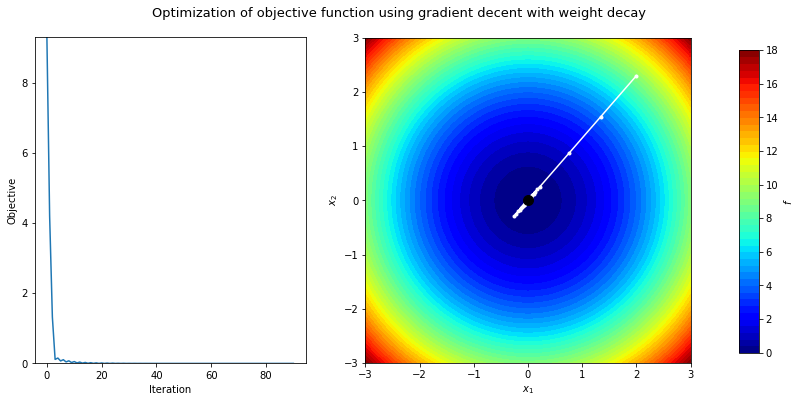

In [6]:
# Batch gradient decent with decaying step factor
x_a_gd_decay, obj_a_gd_decay = GD_AjustDecay(objective_a, gradient_a, np.array([2.0,2.3]), 1.0, 0.9, 100)
x_a_gd_decay = np.asarray(x_a_gd_decay)

GD_plotting_function(xx_a, eval_obj_a, x_a_gd_decay, obj_a_gd_decay, 'Optimization of objective function using gradient decent with weight decay')

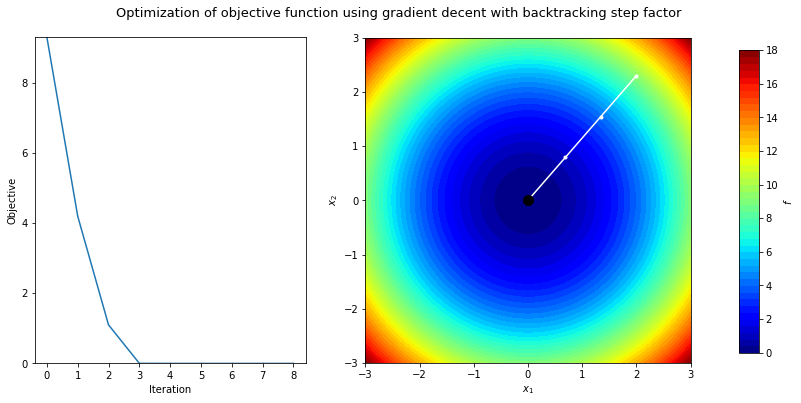

In [7]:
# Batch gradient decent with backtracking step factor 
x_a_gd_backtrack, obj_a_gd_backtrack = GD_AjustBacktrack(objective_a, gradient_a, np.array([2.0,2.3]), 1.0, 100)
x_a_gd_backtrack = np.asarray(x_a_gd_backtrack)

GD_plotting_function(xx_a, eval_obj_a, x_a_gd_backtrack, obj_a_gd_backtrack, 'Optimization of objective function using gradient decent with backtracking step factor')

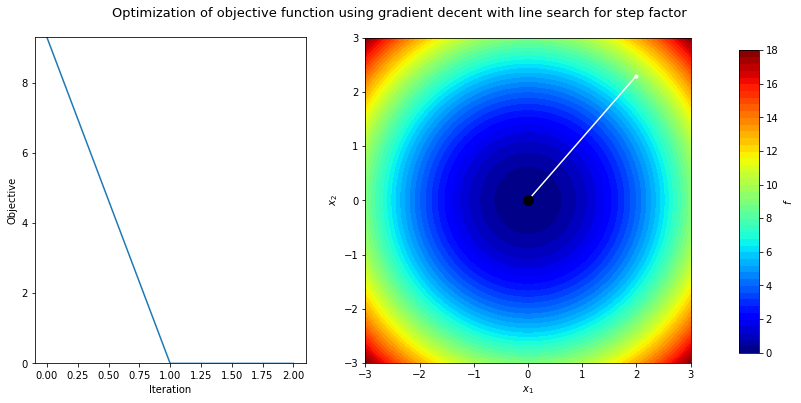

In [8]:
# Batch gradient decent with line search for step factor 
x_a_gd_ls, obj_a_gd_ls = GD_AjustLineSearch(objective_a, gradient_a, np.array([2.0,2.3]), 1.0, 100)
x_a_gd_ls = np.asarray(x_a_gd_ls)

GD_plotting_function(xx_a, eval_obj_a, x_a_gd_ls, obj_a_gd_ls, 'Optimization of objective function using gradient decent with line search for step factor')

#### Objective function B

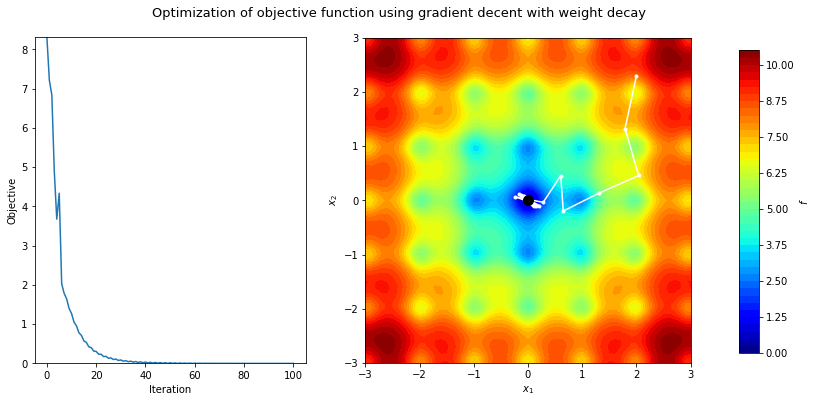

In [9]:
# Batch gradient decent with decaying step factor
x_b_gd_decay, obj_b_gd_decay = GD_AjustDecay(objective_b, gradient_b, np.array([2.0,2.3]), 1.0, 0.9, 100)
x_b_gd_decay = np.asarray(x_b_gd_decay)

GD_plotting_function(xx_b, eval_obj_b, x_b_gd_decay, obj_b_gd_decay, 'Optimization of objective function using gradient decent with weight decay')

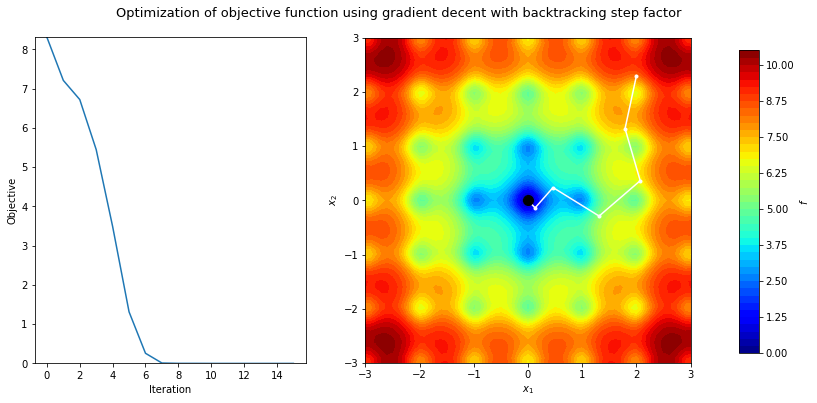

In [10]:
# Batch gradient decent with backtracking step factor 
x_b_gd_backtrack, obj_b_gd_backtrack = GD_AjustBacktrack(objective_b, gradient_b, np.array([2.0,2.3]), 1, 100)
x_b_gd_backtrack = np.asarray(x_b_gd_backtrack)

GD_plotting_function(xx_b, eval_obj_b, x_b_gd_backtrack, obj_b_gd_backtrack, 'Optimization of objective function using gradient decent with backtracking step factor')

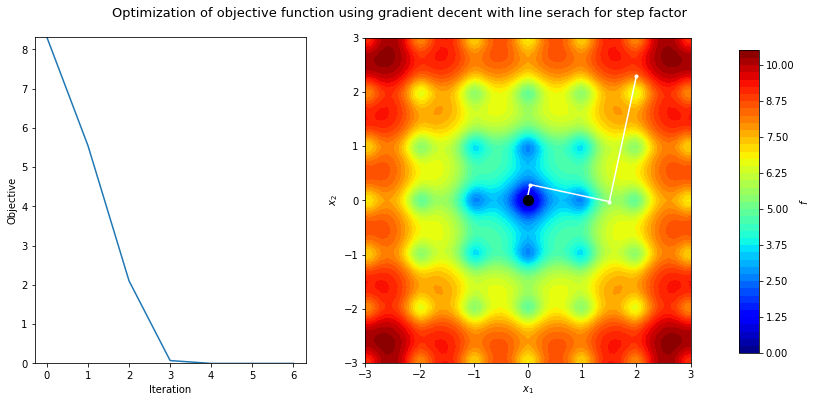

In [11]:
# Batch gradient decent with line search for step factor 
x_b_gd_ls, obj_b_gd_ls = GD_AjustLineSearch(objective_b, gradient_b, np.array([2.0,2.3]), 1, 100)
x_b_gd_ls = np.asarray(x_b_gd_ls)

GD_plotting_function(xx_b, eval_obj_b, x_b_gd_ls, obj_b_gd_ls, 'Optimization of objective function using gradient decent with line serach for step factor')

## Conjugate gradient decent

In this section, we implement and test the conjugate gradient decent algorithm, with the Polak-Ribiere updating rule, on objective function A and B. 

In [12]:
def conjugate_gradient_decent(f_obj, g_obj, xv0, alpha0, gamma0, kmax=100, precision=1.0e-8):
    xv = xv0
    obj = f_obj(xv)
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    # loop
    for k in range(kmax):
        
        if (k==0):
            g_1 = g_obj(xv) # new gradient
            d_1 = - g_1
        else:
            g_0 = g_1
            d_0 = d_1
            # Update
            g_1 = g_obj(xv) # new gradient
            beta = np.max([0.0, np.dot( g_1, g_1 - g_0 ) / np.dot(g_0, g_0) ]); # beta (latency) paremeter 
            d_1 = - g_1 + beta * d_0
        
        # Line search
        alpha = LineSearch(f_obj, xv,  d_1)
        if (alpha==None): alpha = alpha0 # if the search did not converge
        xv +=  alpha * d_1
        obj = f_obj(xv)
        # print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        # book keeping
        xTrace.append(xv.copy())
        objTrace.append(obj.copy())
        
        # convergance (early stopping)
        if abs( objTrace[k+1] - objTrace[k] ) <= precision:
               break   
    # Output            
    return(xTrace, objTrace)

### Results
#### Objective function A

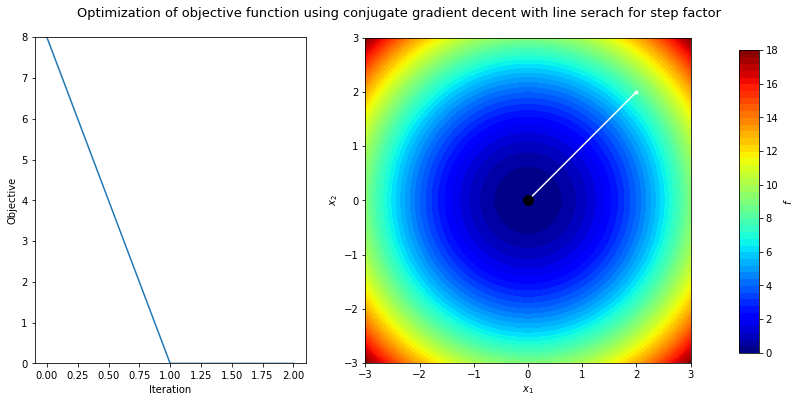

In [13]:
# Conjugate gradient decent with line search for step factor 
x_a_cgd_ls, obj_a_cgd_ls = conjugate_gradient_decent(objective_a, gradient_a, np.array([2.0,2.0]), 1, 100)
x_a_cgd_ls = np.asarray(x_a_cgd_ls)

GD_plotting_function(xx_a, eval_obj_a, x_a_cgd_ls, obj_a_cgd_ls, 'Optimization of objective function using conjugate gradient decent with line serach for step factor')

#### Objective function B

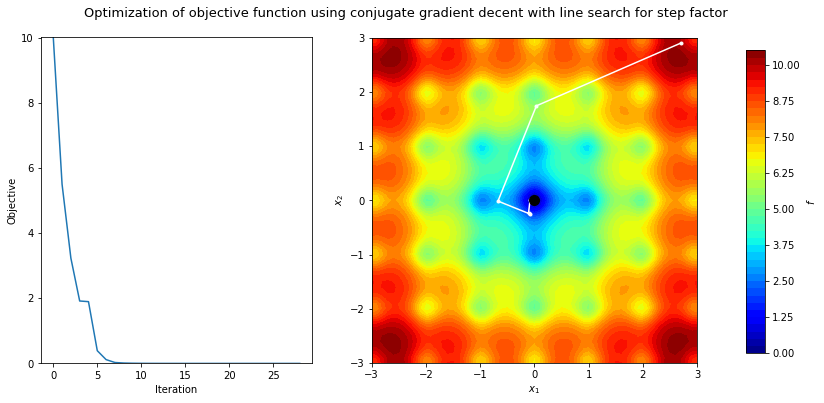

In [14]:
# Conjugate gradient decent with line search for step factor 
x_b_cgd_ls, obj_b_cgd_ls = conjugate_gradient_decent(objective_b, gradient_b, np.array([2.7,2.9]), 1, 100)
x_b_cgd_ls = np.asarray(x_b_cgd_ls)

GD_plotting_function(xx_b, eval_obj_b, x_b_cgd_ls, obj_b_cgd_ls, 'Optimization of objective function using conjugate gradient decent with line search for step factor')

## Adam

In this section, we implement and test the adaptive movement estimation, or Adam, algorithm on objective function A and B. 

In [15]:
def adam_algorithm(f_obj, g_obj, xv0, alpha=0.001, gv=0.9, gs=0.999, eta=1.0e-8, kmax=100):
    xv = xv0
    obj = f_obj(xv)
    v_0 = np.zeros(len(xv))
    s_0 = np.zeros(len(xv))
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    # loop
    for k in range(kmax):
        if (k > 0):
            v_0 = v_1
            s_0 = s_1
        
        # Update
        g_1 = g_obj(xv) # new gradient
        v_1 = gv*v_0 + (1.0 - gv)*g_1 # biased momentum
        s_1 = gs*s_0 + (1.0 - gs)*g_1**2 # biased sq. gradient
        vhat_1 = v_1 / (1 - gv**(k+1)) # corrected momentum
        shat_1 = s_1 / (1 - gs**(k+1)) # corrected sq. gradient
        d_1 = - vhat_1 / (eta + np.sqrt(shat_1)) # search direction
        
        xv +=  alpha * d_1  # a line search for alpha could be included before this step
        obj = f_obj(xv)
#         print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        # book keeping
        xTrace.append(xv.copy())
        objTrace.append(obj.copy())
        
        # convergance (early stopping)
        if abs( objTrace[k+1] - objTrace[k] ) <= eta:
               break   
    # Output            
    return(xTrace, objTrace)

### Results
#### Objective function A

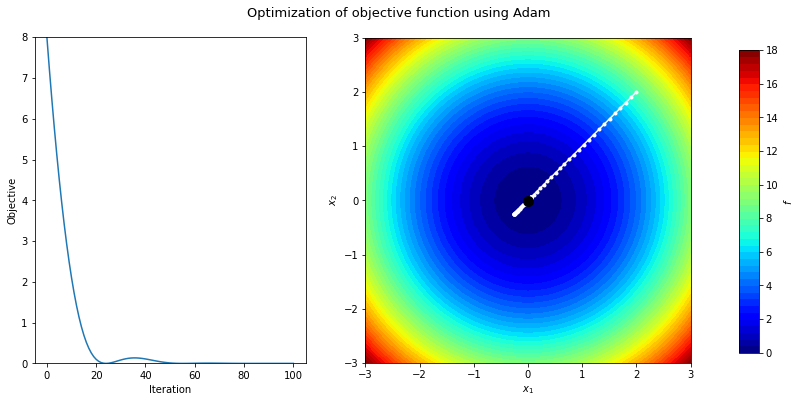

In [16]:
# Adam
x_a_adam, obj_a_adam = adam_algorithm(objective_a, gradient_a, np.array([2.0,2.0]), alpha=0.1, gv=0.9, gs=0.999, eta=1.0e-8, kmax=100)
x_a_adam = np.asarray(x_a_adam)

GD_plotting_function(xx_a, eval_obj_a, x_a_adam, obj_a_adam, 'Optimization of objective function using Adam')

#### Objective function B

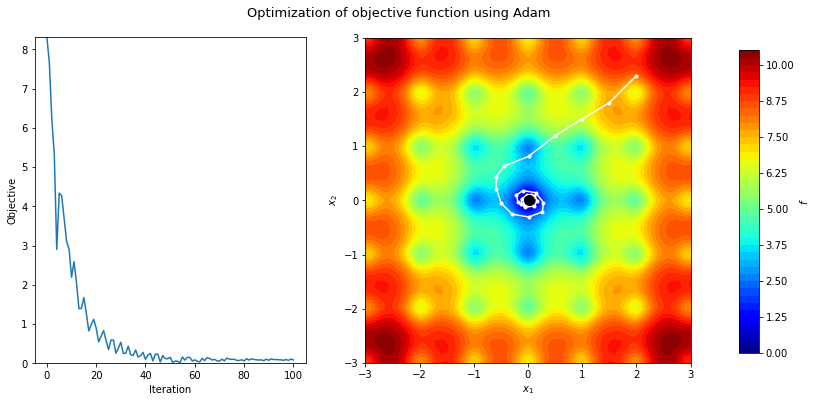

In [17]:
# Adam
x_b_adam, obj_b_adam = adam_algorithm(objective_b, gradient_b, np.array([2.0,2.3]), alpha=0.5, gv=0.9, gs=0.999, eta=1.0e-8, kmax=100)
x_b_adam = np.asarray(x_b_adam)

GD_plotting_function(xx_b, eval_obj_b, x_b_adam, obj_b_adam, 'Optimization of objective function using Adam')

# Second-order methods

In this section, we consider a set of local, second-order optimization algorithms, namely Newton's method and some quasi-Newton methods.

## Newton's method

In the section, we implement Newton’s method and test the implementation on objective A. Newtons methods requires us to define the Hessian, which becomes tedious for complex functions, like e.g., objective B.

In [18]:
def newtons_method(f_obj, g_obj, h_obj, xv0, alpha0=1, kmax=100, precision=1.0e-8):
    xv = xv0
    alpha = alpha0 # can be replased with a line search in the loop
    obj = f_obj(xv)
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    # loop
    for k in range(kmax):
         
        # Update
        g_1 = g_obj(xv) # new gradient
        H_1 = h_obj(xv) # new hessian matrix
        d_1 = - np.linalg.solve(H_1,g_1) # search direction
        
        xv +=  alpha * d_1  # a line search for alpha could be included before this step
        obj = f_obj(xv)
#         print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        
        # book keeping
        xTrace.append(xv.copy())
        objTrace.append(obj.copy())
        
        # convergance (early stopping)
#         if abs( objTrace[k+1] - objTrace[k] ) <= eta:
#                break  
        if np.linalg.norm(d_1) <= precision:
            break 
    # Output            
    return(xTrace, objTrace)

### Results
#### Objective function A

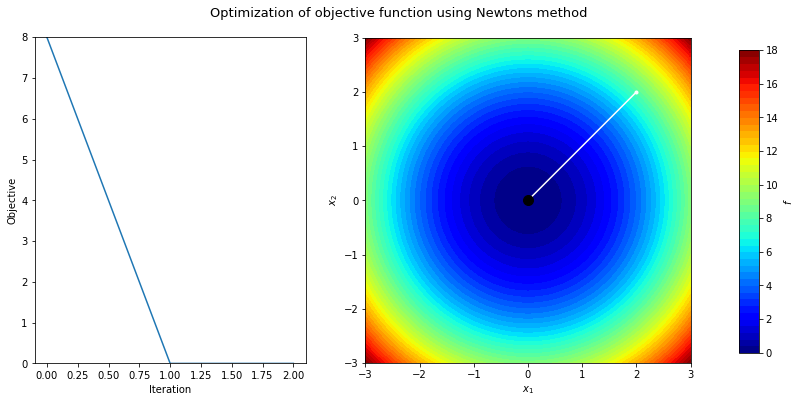

In [19]:
# Newton's method
x_a_newton, obj_a_newton = newtons_method(objective_a, gradient_a, hessian_a, np.array([2.0,2.0]))
x_a_newton = np.asarray(x_a_newton)

GD_plotting_function(xx_a, eval_obj_a, x_a_newton, obj_a_newton, 'Optimization of objective function using Newtons method')

## Quasi-Newton methods

In the section, we implement some quasi-Newton methods and test the implementations on both objective A and B. These methods approximate the inverse Hessian, and only need the gradient to be specified (like first-order methods).

In [20]:
###########################################################################
# DFP - Davidon-Fletcher-Powell
###########################################################################
def DFP(f_obj, g_obj, xv0, alpha0=1.0, kmax=100, precision=1.0e-8):
    xv = xv0
    obj = f_obj(xv)
    Qm = np.eye(len(xv)) # initialize to identity matrix
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    # loop
    for k in range(kmax):
        
        if (k==0):
            g_0 = g_obj(xv) # new gradient
        else:
            g_0 = g_1
            
        d_0 = - np.dot(Qm, g_0)
        # Line search
        alpha = LineSearch(f_obj, xv,  d_0)
        if (alpha==None): alpha = alpha0 # if the search did not converge
        # new x
        xv += alpha * d_0
        obj = f_obj(xv)
        # print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        # new Q
        g_1 = g_obj(xv)
        delta = (xv - xTrace[k]); delta = delta[:,np.newaxis]
        gamma = (g_1 - g_0); gamma = gamma[:,np.newaxis]
        Qm -= Qm@(gamma)@(gamma.T)@Qm / ((gamma.T)@Qm@gamma) + delta@(delta.T) / ((delta.T)@gamma)
        # book keeping
        xTrace.append(xv.copy())
        objTrace.append(obj.copy())
        
        # convergance (early stopping)
        if abs( objTrace[k+1] - objTrace[k] ) <= precision:
               break   
#         if np.linalg.norm(d_0) <= precision:
#             break 
    # Output            
    return(xTrace, objTrace)

###########################################################################
# BFGS - Broydon-Fletcher-Goldfarb-Shannon
###########################################################################
def BFGS(f_obj, g_obj, xv0, alpha0=1.0, kmax=100, precision=1.0e-8):
    xv = xv0
    obj = f_obj(xv)
    Qm = np.eye(len(xv)) # initialize to identity matrix
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    # loop
    for k in range(kmax):
        
        if (k==0):
            g_0 = g_obj(xv) # new gradient
        else:
            g_0 = g_1
            
        d_0 = - np.dot(Qm, g_0)
        # Line search
        alpha = LineSearch(f_obj, xv,  d_0)
        if (alpha==None): alpha = alpha0 # if the search did not converge
        # new x
        xv += alpha * d_0
        obj = f_obj(xv)
        # print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        # new Q
        g_1 = g_obj(xv)
        delta = (xv - xTrace[k]); delta = delta[:,np.newaxis]
        gamma = (g_1 - g_0); gamma = gamma[:,np.newaxis]
        denom = ((delta.T)@gamma) + 1e-16
        Qm -= ( (delta@(gamma.T)@Qm + Qm@gamma@(delta.T)) / denom ) + (1 + (gamma.T)@Qm@gamma / denom)*( delta@(delta.T) / denom)
        # book keeping
        xTrace.append(xv.copy())
        objTrace.append(obj.copy())
        
        # convergance (early stopping)
        if abs( objTrace[k+1] - objTrace[k] ) <= precision:
               break   
#         if np.linalg.norm(d_0) <= precision:
#             break 
    # Output            
    return(xTrace, objTrace)

### Results
#### Objective function A

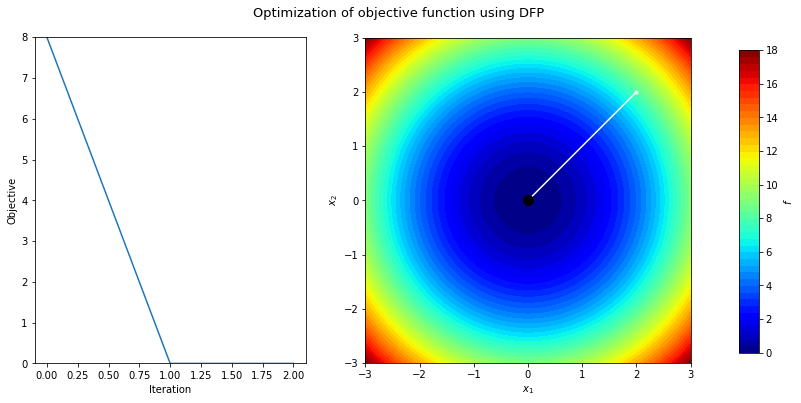

In [21]:
# DFP
x_a_dfp, obj_a_dfp = DFP(objective_a, gradient_a, np.array([2.0,2.0]))
x_a_dfp = np.asarray(x_a_dfp)

GD_plotting_function(xx_a, eval_obj_a, x_a_dfp, obj_a_dfp, 'Optimization of objective function using DFP')

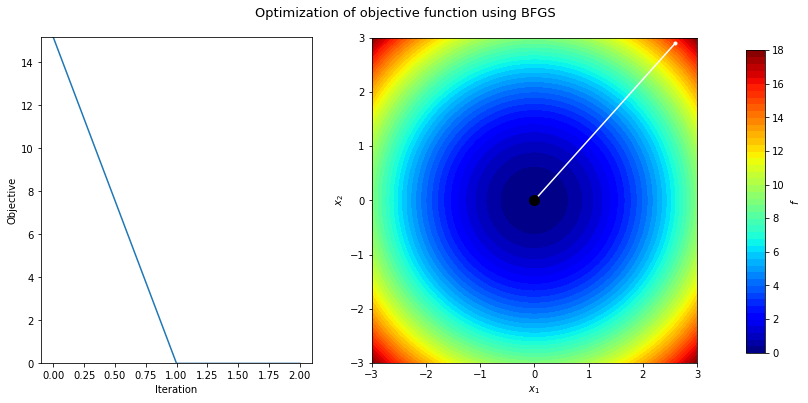

In [22]:
# BFGS
x_a_bfgs, obj_a_bfgs = BFGS(objective_a, gradient_a, np.array([2.6,2.9]))
x_a_bfgs = np.asarray(x_a_bfgs)

GD_plotting_function(xx_a, eval_obj_a, x_a_bfgs, obj_a_bfgs, 'Optimization of objective function using BFGS')

#### Objective function B

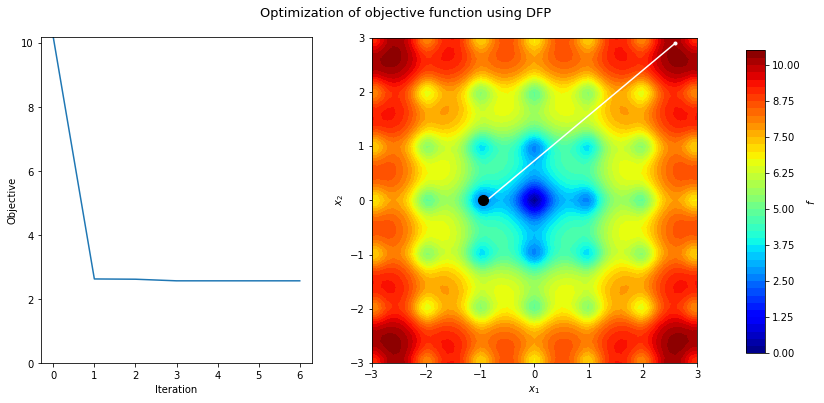

In [23]:
# DFP
x_b_dfp, obj_b_dfp = DFP(objective_b, gradient_b, np.array([2.6,2.9]))
x_b_dfp = np.asarray(x_b_dfp)

GD_plotting_function(xx_b, eval_obj_b, x_b_dfp, obj_b_dfp, 'Optimization of objective function using DFP')

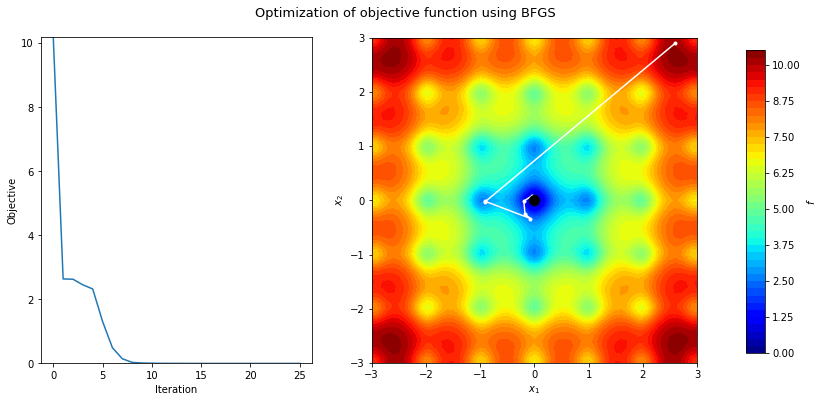

In [24]:
# BFGS
x_b_bfgs, obj_b_bfgs = BFGS(objective_b, gradient_b, np.array([2.6,2.9]))
x_b_bfgs = np.asarray(x_b_bfgs)

GD_plotting_function(xx_b, eval_obj_b, x_b_bfgs, obj_b_bfgs, 'Optimization of objective function using BFGS')

# Direct methods

In this section, we consider a set of direct optimization algorithms, namely coordinate decent and the Nelder-Mead simplex method. These methods rely solely on the objective function, and thus no derivatives are needed. As a consequence, the methods are also sometimes referred to as derivative-free methods.

## Coordinate decent

In the section, we implement the cordinate decent method and test the implementation on both objective A and B. In each iteration, this method cycles through the coordinates one at a time, while performing a line-search along the current coordinate direction. 

In [25]:
###########################################################################
# Basis function
###########################################################################
def Basis_CoorDecent(i,n):
    basis_i = np.zeros(n)
    basis_i[i] = 1
    return(basis_i)

###########################################################################
# Coordinate decent
###########################################################################
def CoorDecent(f_obj, xv0, alpha0, kmax=100, precision=1e-8):
    xv = xv0
    obj = f_obj(xv)
    nx = len(xv)
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    for k in range(kmax):
        for i in range(nx):
            d_ki = Basis_CoorDecent(i,nx)
            alpha_ki = LineSearch(f_obj, xv, d_ki)
            if (alpha_ki==None): alpha_k = alpha0 # if the search did not converge
            xv +=  alpha_ki * d_ki
            obj = f_obj(xv)
#         print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        # book keeping
        xTrace.append(xv.copy())
        objTrace.append(obj.copy())
        # convergance (early stopping)
        if abs( objTrace[k+1] - objTrace[k] ) <= precision:
               break
    # Output    
    return(xTrace, objTrace)

###########################################################################
# Coordinate decent with acceleration
###########################################################################
def CoorDecent_acc(f_obj, xv0, alpha0, kmax=100, precision=1e-8):
    xv = xv0
    obj = f_obj(xv)
    nx = len(xv)
    # book keeping
    xTrace = list(); xTrace.append(xv.copy())
    objTrace = list(); objTrace.append(obj.copy())
    for k in range(kmax):
        xv_k0 = xv.copy()
        for i in range(nx):
            d_ki = Basis_CoorDecent(i,nx)
            alpha_ki = LineSearch(f_obj, xv, d_ki)
            if (alpha_ki==None): alpha_k = alpha0 # if the search did not converge
            xv +=  alpha_ki * d_ki
            obj = f_obj(xv)
#         print('Iteration %d: f(%s) = %.5f' % (k, xv, obj))
        d_k0 = xv - xv_k0
        alpha_k0 = LineSearch(f_obj, xv, d_k0)
        if (alpha_ki==None): alpha_k = alpha0 # if the search did not converge
        xv +=  alpha_k0 * d_k0
        # book keeping
        xTrace.append(xv.copy())
        objTrace.append(obj.copy())
        # convergance (early stopping)
        if abs( objTrace[k+1] - objTrace[k] ) <= precision:
               break
    # Output    
    return(xTrace, objTrace)

### Results
#### Objective function A

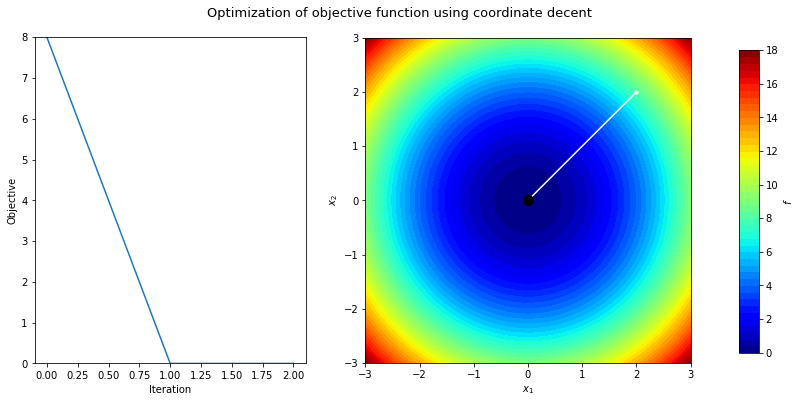

In [26]:
# Coordinate Decent
x_a_coor, obj_a_coor = CoorDecent(objective_a, np.array([2.0,2.0]), 0, 100)
x_a_coor = np.asarray(x_a_coor)

GD_plotting_function(xx_a, eval_obj_a, x_a_coor, obj_a_coor, 'Optimization of objective function using coordinate decent')

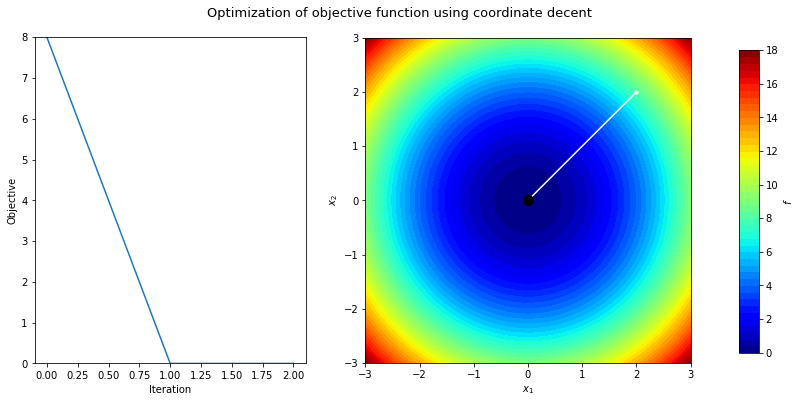

In [27]:
# Coordinate Decent with acceleration step
x_a_coorAcc, obj_a_coorAcc = CoorDecent_acc(objective_a, np.array([2.0,2.0]), 0, 100)
x_a_coorAcc = np.asarray(x_a_coorAcc)

GD_plotting_function(xx_a, eval_obj_a, x_a_coorAcc, obj_a_coorAcc, 'Optimization of objective function using coordinate decent')

#### Objective function B

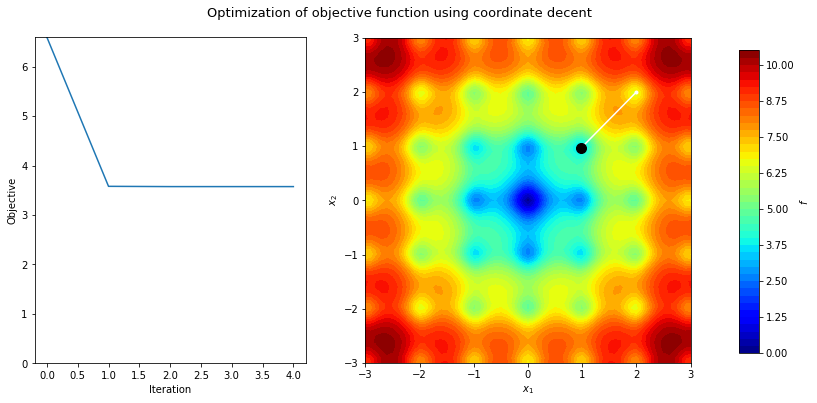

In [28]:
# CoorDecent
x_b_coor, obj_b_coor = CoorDecent(objective_b, np.array([2.0,2.0]), 0, 100)
x_b_coor = np.asarray(x_b_coor)

GD_plotting_function(xx_b, eval_obj_b, x_b_coor, obj_b_coor, 'Optimization of objective function using coordinate decent')

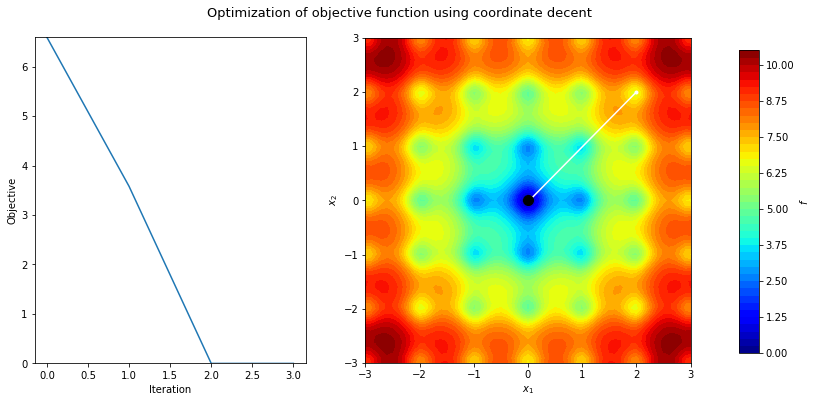

In [29]:
# Coordinate Decent with acceleration step
x_b_coorAcc, obj_b_coorAcc = CoorDecent_acc(objective_b, np.array([2.0,2.0]), 0, 100)
x_b_coorAcc = np.asarray(x_b_coorAcc)

GD_plotting_function(xx_b, eval_obj_b, x_b_coorAcc, obj_b_coorAcc, 'Optimization of objective function using coordinate decent')

## Nelder-Mead simplex method

In the section, we implement the Nelder-Mead simplex method and test the implementation on both objective A and B. This algorithm uses a simplex to traverse the search space while making use of a set of decision rules for reflection, expansion, contraction, and shrinkage. 

In [30]:
###########################################################################
# Nelder-Mead simplex method
###########################################################################
def NMSM(f_obj, S0, alpha=1, beta=2, gamma=0.5, kmax=100, precision=1e-4):
    S = S0
    obj = f_obj(list([S[:,0], S[:,1]]))
    nS, mS = S.shape; # print(nS,mS)
    order = np.argsort(obj)
    S, obj = S[order, :], obj[order]; # print(S, Obj)
    # book keeping
    xTrace = list(); xTrace.append(S.copy())
    objTrace = list(); objTrace.append(obj.copy())
    
    for k in range(kmax):
        xl, yl = S[0,:], obj[0]; # print(xl,yl) # lowest (first) value
        xh, yh = S[nS-1,:], obj[nS-1]; # print(xh,yh) # highest (last) value
        xs, ys = S[nS-2,:], obj[nS-2]; # print(xs,ys) # second highest (last) value
        xm = np.mean(S[:nS-1,:], axis=0); # print(xm) # centroid (excluding the highest value point)
        xr = xm + alpha*(xm - xh) # reflecting point
        yr = f_obj(xr); # print(xr,yr)
        
        if yr < yl:
            xe = xm + beta*(xr - xm) # expansion point
            ye = f_obj(xe); # print(xe,ye)
            S[nS-1,:], obj[nS-1] = (xe, ye) if ye < yr else (xr, yr)
        elif yr >= ys:
            if yr <= yh:
                xh, yh, S[nS-1,:], obj[nS-1] = xr, yr, xr, yr
            xc = xm + gamma*(xh - xm) # contraction point
            yc = f_obj(xc)
            if yc > yh:
                for i in np.arange(1,nS):
                    S[i,:] = (S[i,:] + xl)/2
                    obj[i] = f_obj(S[i,:])
            else:
                S[nS-1,:], obj[nS-1] = xc, yc
        else:
            S[nS-1,:], obj[nS-1] = xr, yr
        
        order = np.argsort(obj)
        S, obj = S[order, :], obj[order]; # print(S, Obj)
        # book keeping
        xTrace.append(S.copy())
        objTrace.append(obj.copy())
        # convergance (early stopping)
        if np.std(obj) <= precision:
               break
    # Output    
    return(xTrace, objTrace)

### Results
#### Objective function A

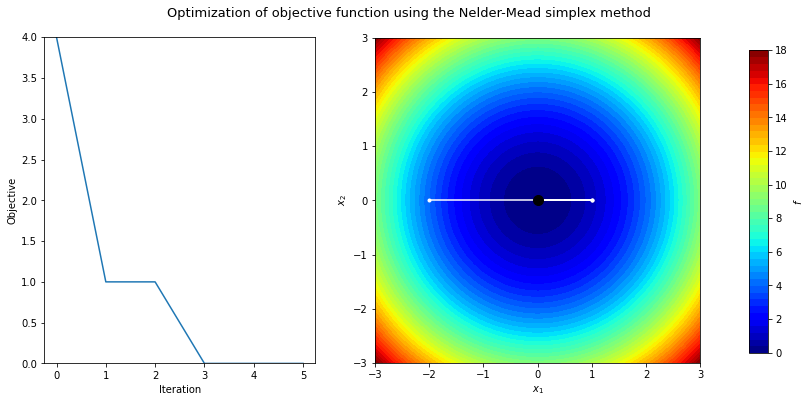

In [31]:
# Nelder-Mead simplex method
S_a_nmsm, obj_a_nmsm = NMSM(objective_a,  np.array([[2,2], [2,-2], [-2,0]]))
nIt = len(obj_a_nmsm)
x_a_nmsm = np.zeros([nIt,2])
y_a_nmsm = np.zeros([nIt])
for t in range(len(obj_a_nmsm)):
    x_a_nmsm[t,:] = S_a_nmsm[t][0,:] # lowest value
    y_a_nmsm[t] = obj_a_nmsm[t][0]
    
GD_plotting_function(xx_a, eval_obj_a, x_a_nmsm, y_a_nmsm, 'Optimization of objective function using the Nelder-Mead simplex method')

#### Objective function B

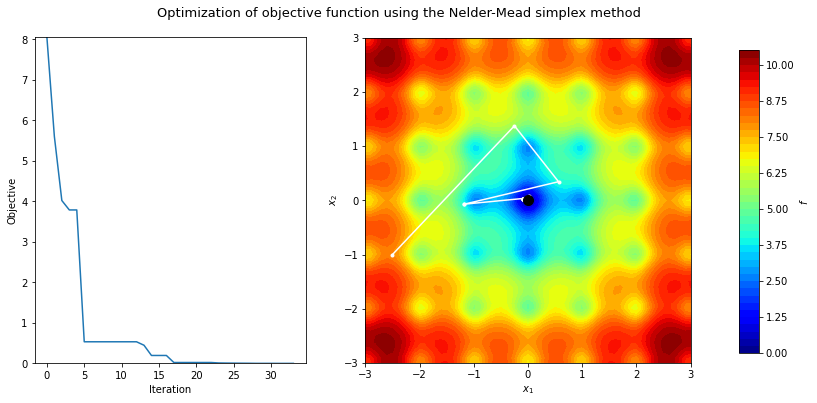

In [32]:
# Nelder-Mead simplex method
S_b_nmsm, obj_b_nmsm = NMSM(objective_b,  np.array([[-2.5,-1], [-0.5,3], [2.5,0.5]]))
nIt = len(obj_b_nmsm)
x_b_nmsm = np.zeros([nIt,2])
y_b_nmsm = np.zeros([nIt])
for t in range(len(obj_b_nmsm)):
    x_b_nmsm[t,:] = S_b_nmsm[t][0,:] # lowest value
    y_b_nmsm[t] = obj_b_nmsm[t][0]
    
GD_plotting_function(xx_b, eval_obj_b, x_b_nmsm, y_b_nmsm, 'Optimization of objective function using the Nelder-Mead simplex method')